# Project 1: Centrality Measures with Airports and Flight Routes
By Shyam Balagurumurthy and Latif Masud

# Introduction

For this project, we chose to look at a dataset of airports and airline routes. The dataset was taken from [OpenFlights](https://openflights.org/data.html) containing airports, routes, and airline information. Using this dataset, we built out both neo4j and networkX graphs, and performed various analyses on them. 

# Loading the Data

Below are the libraries we needed for the project. `networkx` `urllib`, `matplotlib`, `nxviz`, and `numpy` are all used for centrality measurement, while `basemap` is used for map visualization. `neo4j` is pulled in to drive the interaction between the database. 

In [53]:
import networkx as net
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import nxviz as nv
import numpy as np
from operator import itemgetter
from mpl_toolkits.basemap import Basemap
from neo4j.v1 import GraphDatabase, basic_auth
from math import radians, cos, sin, asin, sqrt


We chose to use neo4j as our graph database of choice since it is easy to work with, has an user interface, and we have prior experience with it in the past. To start, we define a couple of functions to help us acquire the data. The `clean_line` function simply takes in a string, checks for a set of predefined invalid values, and eliminates those values from the string. This is done to ensure escape characters such as `\n` and `'` are taken out before we process on those strings. 

The `extract_data` function is the main function that performs the data extraction. It opens up a given file path, reads in the lines, and then converts the lines to a Python dictionary, which is then returned. There is a bit of functional programming used to make the code simpler. The `zip` function creates a pairwise list from two different arrays, so we define properties for each of the packages we want to look at. For example, when we are uploading airport information, we first define properties in `airport_props` with fields such as the `name`, `city`, `country`, etc that matchup exactly with the dataset. The `zip` function then lines up the values, and we create a dictionary from those values, which is then appended to a list. 

In [54]:
def clean_line(line):
    invalids = ['"', '\n']
    for n in invalids:
        line = line.replace(n, '')
        
    return line

def extract_data(file_loc, props):
    # Read in file
    file_obj = open(file_loc, "r",encoding="utf8")
    lines = file_obj.readlines()
    file_obj.close()
    

    #Takes the lines that were read in, does a split to create an array, then zips
    #with the props to create a 2d array, and then forms a dictionary from that 2d array,
    #and returns a list of those dictionaries.
    return list(map(lambda x: dict(zip(props, clean_line(x).split(","))), lines))
    

Below are the defined properties for airports, routes, and airlines. They are taken in by `extract_data` along with the file location to map through, and return dictionaries of the datasets. 

In [55]:
airport_props = [
        "airport_id",
        "name",
        "city",
        "country",
        "iata",
        "icao",
        "lat",
        "lon",
        "altitude",
        "timezone",
        "dst",
        "tz_database_time_zone",
        "type",
        "source"
]

route_props = [
        "airline",
        "airline_id",
        "source_airport",
        "source_airport_id",
        "destination_airport",
        "destination_airport_id",
        "codeshare",
        "stops",
        "equipment"
        ]

airlines_props = ["airline_id",
"name",
"alias",
"iata",
"icao",
"callsign",
"country",
"active"]

To extract the data into Python dictionaries, we simply call the `extract_data` function with the pre-ddefined props.

In [56]:
routes = extract_data("./data/routes.dat", route_props)
airports = extract_data("./data/airports.dat", airport_props)
airlines = extract_data('./data/airlines.dat',airlines_props)[1:]

# Analysis on Neo4j

Once we have the data, we startup our neo4j client. The password field has been left blank for privacy concerns.

In [5]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", ""))
session = driver.session()

ServiceUnavailable: Cannot acquire connection to Address(host='localhost', port=7687)

For each airport, we run the following Cypher query with our connection. We predefine the properties in the query to match the data shape that was defined in `airport_props`, and simply pass along the reference from the loop as `airport`. 

In [ ]:
for airport in airports:
    session.run(
        """CREATE (a:Airport {
            airport_id: {airport_id},
            name: {name},
            city: {city},
            country: {country},
            iata: {iata},
            icao: {icao},
            lat: {lat},
            lon: {lon},
            altitude: {altitude},
            timezone: {timezone},
            dst: {dst},
            tz_database_time_zone: {tz_database_time_zone},
            type: {type},
            type: {source}})""", airport)

Once we have inserted the airports, we can then insert the routes between the airports. We do this by running through the routes in similar fashion as the airports. Once we enter the routes, we choose to link the airports related to that route by running a couple of matches, and creating links between that route and the airports. 

In [ ]:
for route_info in routes:
    route = {"destination": route_info["destination_airport"], "source": route_info["source_airport"]}
    session.run("MATCH(n: Airport {iata: {destination}}) MATCH(v: Airport {iata: {source}}) CREATE (n)-[:flies_to]->(v)", route)

    session.run(
        """CREATE (a:Route {
            airline: {airline},
            airline_id: {airline_id},
            source_airport: {source_airport},
            source_airport_id: {source_airport_id},
            destination_airport: {destination_airport},
            destination_airport_id: {destination_airport_id},
            codeshare: {codeshare},
            stops: {stops},
            equipment: {equipment}})
        """, route_info)

    session.run("MATCH(n: Airport {iata: {source}}) MATCH(v: Route {source_airport: {source}}) CREATE (n)-[:route]->(v)", route)
    session.run("MATCH(n: Airport {iata: {destination}}) MATCH(v: Route {destination_airport: {destination}}) CREATE (n)-[:route]->(v)", route)

When done, we can go on the neo4j web client, and take a look at our data with the following query:
Note: We were only able to include 21,000 routes instead of the full dataset due to limits with memory and processing power. 

In [ ]:
MATCH (n) RETURN n

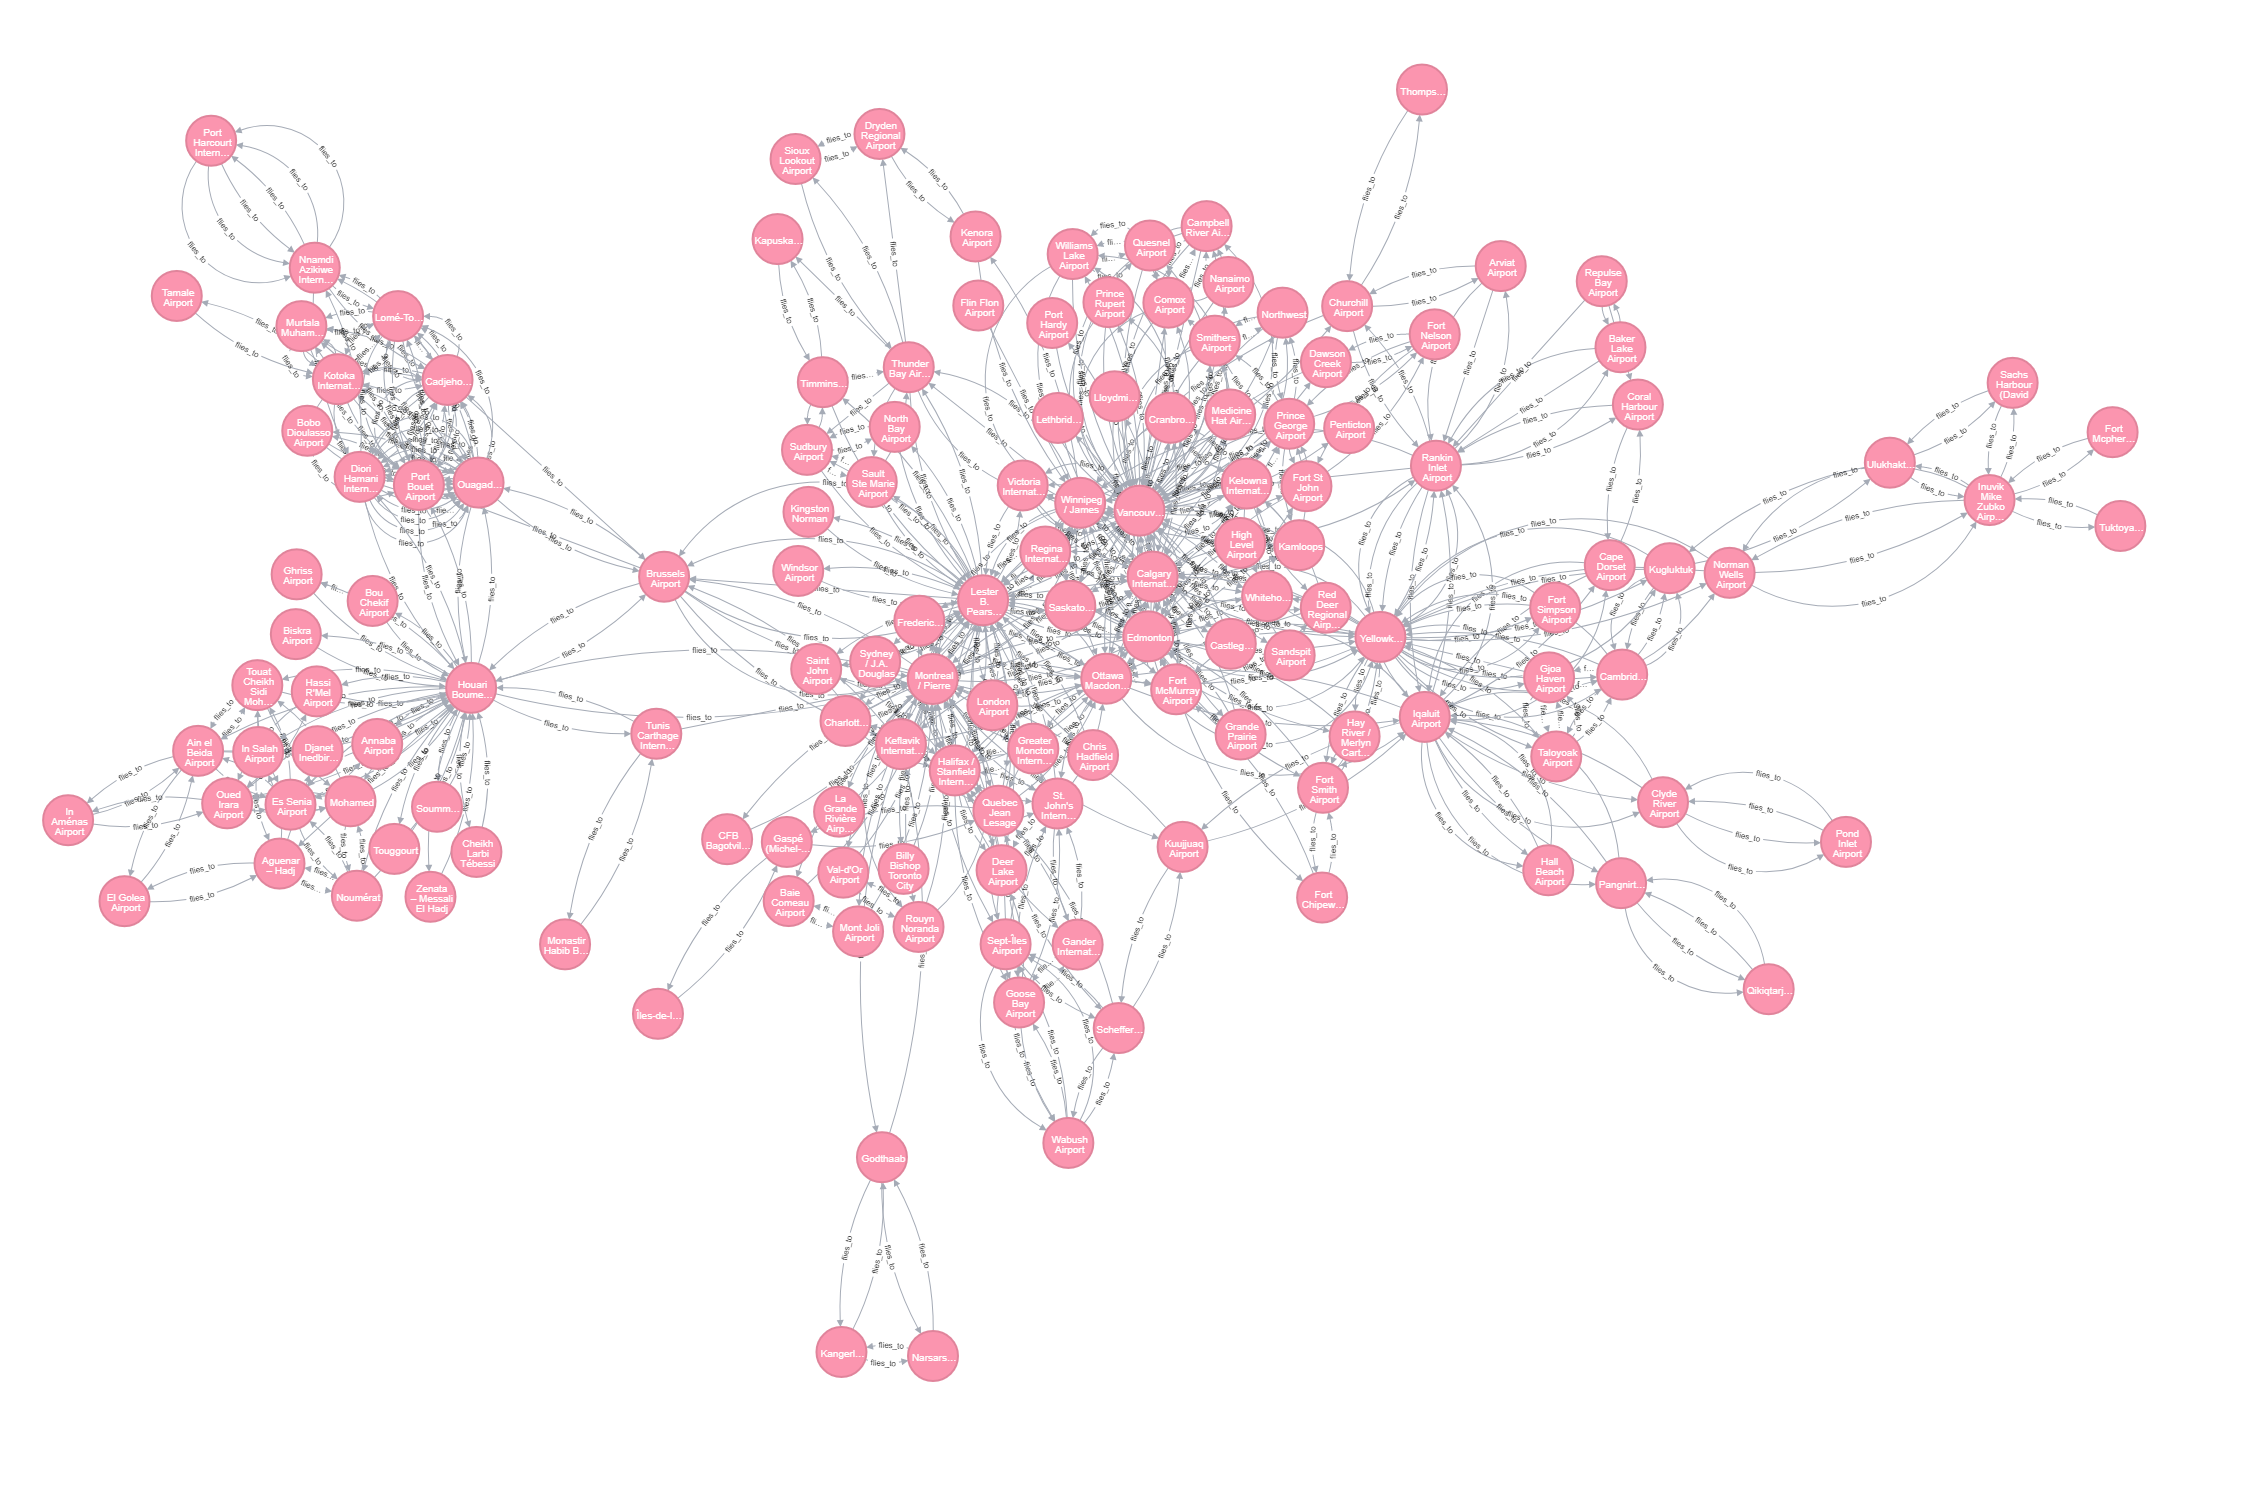

In [2]:
from IPython.display import Image
Image("img/initial_graph.png")

## Data Metrics

The Cypher query below returns the ten airports with the most routes in our database:

In [ ]:
MATCH (a1:Airport)-[:flies_to]->(a2:Airport) 
RETURN a1.name, COUNT(a1) AS airport
ORDER BY airport DESC
LIMIT 10

In [6]:
import pandas as pd
DSI_data_path = "results/ten_most_routes.csv"
DSI_data = pd.read_csv(DSI_data_path)
print DSI_data

                                           "a1.name"  "airport"
0  "Hartsfield Jackson Atlanta International Airp...       1333
1                          "London Heathrow Airport"        709
2          "Charles de Gaulle International Airport"        681
3             "John F Kennedy International Airport"        621
4            "Beijing Capital International Airport"        542
5                "Los Angeles International Airport"        499
6                       "Amsterdam Airport Schiphol"        472
7          "Dallas Fort Worth International Airport"        457
8             "Chicago O'Hare International Airport"        419
9           "Guangzhou Baiyun International Airport"        409


The query below genrates the diamter of the graph. The diameter in thise case would be the most connected routes beween each airport. As we can see in the image below, the most connected airports include popular ones such as 

In [ ]:
START n = node(*) 
MATCH (n)--(c)
RETURN n, count(*) as connections
ORDER BY connections DESC
LIMIT 10

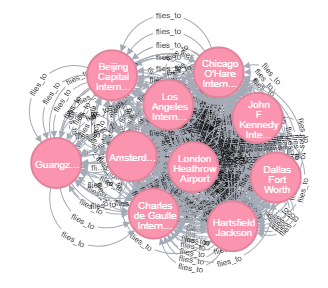

In [7]:
from IPython.display import Image
Image("img/diameter_graph.png")

# Networkx Analysis

Previously we have performed lot of analysis on Neo4j. Currently we will perform some more analysis on this dataset using Networkx package. First lets combine the airlines dataset to routes dataset.

In [57]:
routes_df = pd.DataFrame(routes)
airlines_df = pd.DataFrame(airlines)

In [58]:
routes_airline = routes_df.merge(airlines_df,left_on="airline_id",right_on="airline_id",how="inner")[['airline', 'airline_id', 'codeshare', 'destination_airport',
       'destination_airport_id', 'equipment', 'source_airport',
       'source_airport_id', 'stops','name','active']].to_dict(orient='records')

Create a single directional graph object using netowrkx.

In [59]:
g=net.DiGraph()

In [60]:
for airport in airports:
    g.add_node(airport['iata'], name= airport['name'], city= airport['city'], timezone = airport['timezone'], lat = airport['lat'], lon = airport['lon'])

In [61]:
for route in routes_airline:
    g.add_edge(route['source_airport'],route['destination_airport'], \
               stops =route['stops'],equipment=route['equipment'], airline_id =route['airline_id'], 
              name = route['name'], active =route['active'])

In [88]:
net.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 5885\nNumber of edges: 37064\nAverage in degree:   6.2980\nAverage out degree:   6.2980'

# Circos Plot

Below shown is the circos plot of all the flights and its path.

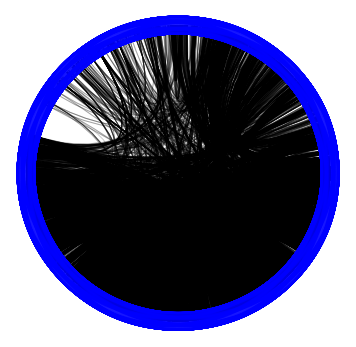

In [11]:
circos_plot = nv.CircosPlot(g)
circos_plot.draw()
plt.show()

# Centrality

Centrality is to find the important nodes in the complete graph or dataset. In the below analysis, we will will find the different airport locations which are important in the complete dataset.

In [62]:
def sorted_map(map1):
    """Defined a function to sort the dictionary"""
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

### Degree Centrality

Outbound degree Centrality - Refers to the number of adjecent airports which is connected from one airport in bi-directional way.

In-degree Centrality - Refers to the number of airports connected with one node which are in inbound way.

In [23]:
deg = net.degree_centrality(g)
d = sorted_map(deg)
print("Degree centrality:{}".format(d[:10]))

in_d = net.in_degree_centrality(g)
print("\nIn-degree centrality:{}".format(sorted_map(in_d)[:10]))

Degree centrality:[('FRA', 0.08097097267017483), ('CDG', 0.07978271940247836), ('AMS', 0.07859446613478187), ('IST', 0.07757596333389917), ('ATL', 0.07350195213036835), ('PEK', 0.0699371923272789), ('ORD', 0.06942794092683754), ('MUC', 0.06450517738923782), ('DME', 0.06416567645561025), ('DFW', 0.06314717365472755)]

In-degree centrality:[('FRA', 0.04040061110168053), ('CDG', 0.03955185876761161), ('AMS', 0.039212357833984045), ('IST', 0.03904260736717026), ('ATL', 0.036666100831777286), ('PEK', 0.03496859616363945), ('ORD', 0.0344593447631981), ('MUC', 0.032082838227805124), ('DME', 0.032082838227805124), ('DFW', 0.03140383636054999)]


### Closeness Centrality

It is the measure of the degree to which an airport is near all the other individual airports in the whole network

In [25]:
cs = net.closeness_centrality(g)
c = sorted_map(cs)

### Betweeness Centrality

Betweenness centrality is an measure of one node connected to other nodes that are not connected to each other. It is a measure of the degree to whch a node serves as a bridge.

In [24]:
bs = net.betweenness_centrality(g)
b = sorted_map(bs)

In [26]:
names1 = [x[0] for x in c[:10]]
names2 = [x[0] for x in d[:10]]
names3 = [x[0] for x in b[:10]]

Finally combine all different types of centrality into one ndarray.

In [27]:
names = list(set(names1) | set(names2) | set(names3))

table = [[name,cs[name], deg[name], bs[name]] for name in names]
table

[['LHR', 0.2227969534989327, 0.05805465965031404, 0.012089483271912414],
 ['PEK', 0.2128278910634966, 0.0699371923272789, 0.01608503439418929],
 ['DME', 0.19230551920269348, 0.06416567645561025, 0.00972697534586278],
 ['ORD', 0.21211666626044962, 0.06942794092683754, 0.015197170173136012],
 ['ANC', 0.16703706259602377, 0.011543031743337293, 0.02243263553984442],
 ['AMS', 0.2196073049162708, 0.07859446613478187, 0.013841615447505088],
 ['YYZ', 0.21329645768345099, 0.04973688677643864, 0.00963902043369885],
 ['JFK', 0.21673712820065724, 0.05465965031403836, 0.008437173479933653],
 ['DFW', 0.2043459624565033, 0.06314717365472755, 0.008214264560896226],
 ['ATL', 0.20491466434467123, 0.07350195213036835, 0.00969141531898216],
 ['IST', 0.21366783863124572, 0.07757596333389917, 0.01363551885875826],
 ['LAX', 0.21781427402771053, 0.05041588864369377, 0.02149552639408095],
 ['CDG', 0.22398983083574858, 0.07978271940247836, 0.020193625794939104],
 ['FRA', 0.22530580536207856, 0.08097097267017483

In [28]:
#Eigen Vector centrality

eigen_vector = net.eigenvector_centrality(g)
eigen_vector_sorted = sorted_map(eigen_vector)
eigen_vector_sorted[:20]

[('AMS', 0.16590687927774386),
 ('FRA', 0.16575008044630718),
 ('CDG', 0.1592158546860886),
 ('MUC', 0.14895040656464503),
 ('LHR', 0.13705737700475443),
 ('FCO', 0.13585895911110474),
 ('IST', 0.12962742769322164),
 ('BCN', 0.12941437300239586),
 ('ZRH', 0.126188568814619),
 ('MAD', 0.12323524213260259),
 ('BRU', 0.1223479909627364),
 ('DUB', 0.11727659539535738),
 ('DUS', 0.11596356376435123),
 ('LGW', 0.11494913501229163),
 ('VIE', 0.11436791195051445),
 ('MAN', 0.11419338031759343),
 ('CPH', 0.10940895804697262),
 ('JFK', 0.10618614604733954),
 ('MXP', 0.10582203071374091),
 ('DXB', 0.10272518192834107)]

# Shortest Path and Distance

As a next analysis we will find the shortest/longest path, km distance between tose path. Also we will find out the airlines involved in those path.

In [63]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two lat/lon points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [64]:
def calculate_distance(g, source,destination):
    """Calculate the distance between two direct locations"""
    mykeys = ('lat','lon')
    myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
    myvalues =[float(x) for x in list(myvalues)]
    return(haversine(*myvalues))

In [65]:
def calculate_distance_chart(g, source,destination):
    """Calculate the distance between two direct locations in the chart"""
    mykeys = ('lat','lon')
    myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
    myvalues =[float(x) for x in list(myvalues)]
    return(plot_chart(*myvalues))

In [66]:
def plot_chart(lon1, lat1, lon2, lat2):
    """Function for plotting a chart and distance between two points"""
    
    # create new figure, axes instances.
    fig=plt.figure()
    ax=fig.add_axes([2.9,2.9,5.8,5.8])
    # setup mercator map projection.
    m = Basemap(llcrnrlon=-300.,llcrnrlat=-60.,urcrnrlon=200.,urcrnrlat=80.,\
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',projection='merc',\
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    # nylat, nylon are lat/lon of New York
    nylat = lon1; nylon = lat1
    # lonlat, lonlon are lat/lon of London.
    lonlat = lon2; lonlon = lat2
    # draw great circle route between NY and London
    m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
    m.drawcoastlines()
    m.fillcontinents()
    # draw parallels
    m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
    # draw meridians
    m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
    ax.set_title('Great Circle')
    plt.figure(figsize=(20,10))
    plt.show()


In [67]:
def calculate_distance1(g, travel_list):
    """Calculate the distance between all the shortest distance between two different locations on 
    earth by using lat/lon"""

    if len(travel_list) ==2:
        source = travel_list[0]
        destination = travel_list[1]
        mykeys = ('lat','lon')
        myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
        myvalues =[float(x) for x in list(myvalues)]
        return(haversine(*myvalues))
    
    else:
        total_km = []
        for i in np.arange(0,len(travel_list)-1):
            total_km.append(calculate_distance1(g, [travel_list[i], travel_list[i+1]]))
        total_km_num = sum(total_km)        
    return(total_km_num)

In [68]:
def airlines_path(path):
    """Return the path of airlines for the given path"""
    return([net.get_edge_attributes(G=g,name='name')[(path[air], path[air+1])] for air in np.arange(0,len(path)-1)])

Below main fucntion uses the help of other functions and calculate below parameters between two requested location. As an inital step it gets two specific location as an input.

1. Calculate all the shortest path between two entered airports.
2. Calculate the total distancein km for the each shortest path.
3. Shows the minimum and maximum distance in km.
4. Shows the route of that min/max paths.
5. Displays the airline which is carries on that path.
6. Finally it displays in a world chart as a distance between two points.

Enter Souce Airport: RDU
Enter Destination Airport: GUM

Least distance path details are... 
Minimum Distance: 15200 
Minimum Distance path: ['RDU', 'ORD', 'HNL', 'GUM'] 
Airlines Details:['US Airways', 'United Airlines', 'United Airlines']

Highest distance path details are... 
Maximum Distance: 26141 
Maximum Distance path: ['RDU', 'LHR', 'NRT', 'GUM'] 
Airlines Details:['US Airways', 'Virgin Atlantic Airways', 'United Airlines']

Dijkstra Path: ['RDU', 'DFW', 'HNL', 'GUM']

All available routes: [(['RDU', 'DFW', 'HNL', 'GUM'], 15228.822222937255), (['RDU', 'JFK', 'HNL', 'GUM'], 16245.938860384449), (['RDU', 'LAX', 'HNL', 'GUM'], 15317.715001816328), (['RDU', 'ORD', 'HNL', 'GUM'], 15199.502003112828), (['RDU', 'ATL', 'HNL', 'GUM'], 15199.827263725576), (['RDU', 'LAS', 'HNL', 'GUM'], 15333.300788046468), (['RDU', 'SLC', 'HNL', 'GUM'], 15382.975464991981), (['RDU', 'SFO', 'HNL', 'GUM'], 15425.673787900336), (['RDU', 'EWR', 'HNL', 'GUM'], 16162.011467476923), (['RDU', 'IAD', 'HNL', 'GUM

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


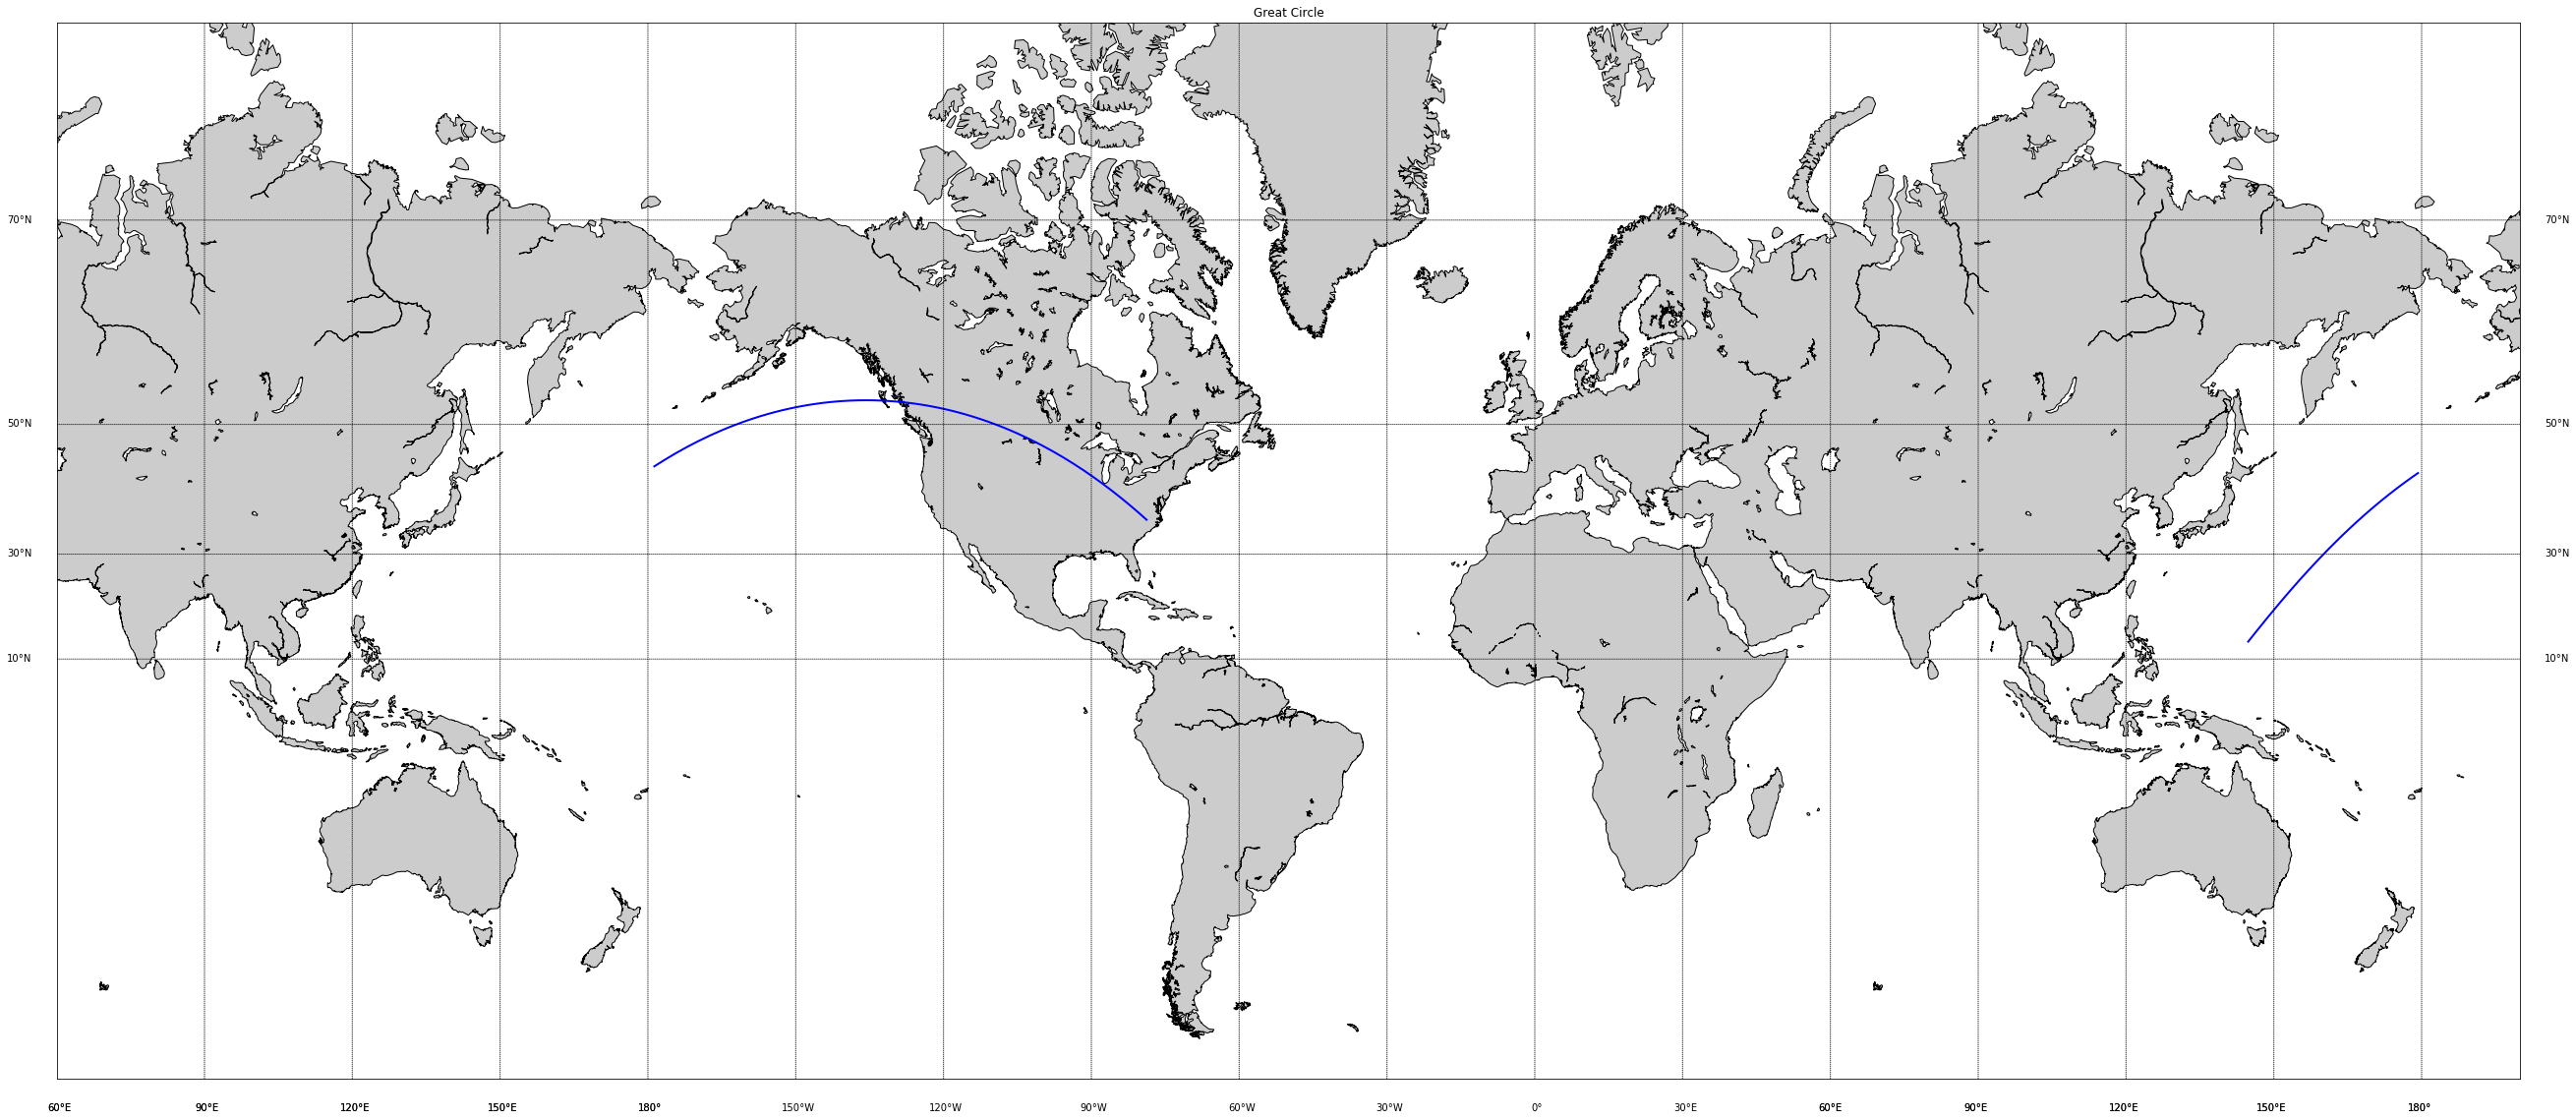

In [89]:
if __name__ == "__main__":
    source = input("Enter Souce Airport: ").upper()
    destination = input("Enter Destination Airport: ").upper()
    
    try:
        all_path = list(net.all_shortest_paths(g, source,destination))
        total_distances = [calculate_distance1(g,path) for path in all_path]
        
        #Calculate the min and max distance path
        min_distance_path = all_path[total_distances.index(min(total_distances))]
        max_distance_path = all_path[total_distances.index(max(total_distances))]
        
        print("\nLeast distance path details are... ")
        
        print("Minimum Distance: {} ".format(round(min(total_distances))))    
        print("Minimum Distance path: {} ".format(min_distance_path))    
        print("Airlines Details:{}".format(airlines_path(min_distance_path))) 
        
    
        print("\nHighest distance path details are... ")
        
        print("Maximum Distance: {} ".format(round(max(total_distances))))    
        print("Maximum Distance path: {} ".format(max_distance_path))    
        print("Airlines Details:{}".format(airlines_path(max_distance_path))) 
        
        print("\nDijkstra Path: {}".format(net.dijkstra_path(g, source,destination)))
    
        print("\nAll available routes: {}".format(list(zip(all_path,total_distances))))
    
        calculate_distance_chart(g,source,destination)
    except:
        print("\nSorry! Flight route does not exist. Or please check the airport code correctly.")

# Top 20 airlines

Now lets try to figure out the top 20 airlines which sends and manages many flight routes.

In [70]:
all_airlines = list(net.get_edge_attributes(g,name='name').values())

In [71]:
airlines_count = {i:all_airlines.count(i) for i in all_airlines}

Below listed airlines manages many different routes.

In [72]:
sorted_map(airlines_count)[:20]

[('Ryanair', 2119),
 ('US Airways', 1725),
 ('United Airlines', 1576),
 ('Southwest Airlines', 1144),
 ('easyJet', 1005),
 ('Delta Air Lines', 882),
 ('Shenzhen Airlines', 815),
 ('China Eastern Airlines', 801),
 ('Turkish Airlines', 592),
 ('Wizz Air', 463),
 ('China Southern Airlines', 441),
 ('Lufthansa', 411),
 ('KLM Royal Dutch Airlines', 406),
 ('Aeroflot Russian Airlines', 398),
 ('Scandinavian Airlines System', 395),
 ('Formosa Airlines', 372),
 ('Allegiant Air', 358),
 ('All Nippon Airways', 347),
 ('WestJet', 341),
 ('Norwegian Air Shuttle', 291)]

# Shortest path with weighted routes

In [77]:
g_weighted = g.copy()

In [86]:
def calculate_distance_test(g, source,destination):
    """Calculate the distance between two direct locations"""
    mykeys = ('lat','lon')
    print(g.nodes(data=True)[1])
    myvalues = (*itemgetter(*mykeys)(g.node[source]),*itemgetter(*mykeys)(g.node[destination]))
    myvalues =[float(x) for x in list(myvalues)]
    return(haversine(*myvalues))

In [87]:


for route in routes_airline:
    g_weighted.add_edge(route['source_airport'],route['destination_airport'], \
               stops =route['stops'],equipment=route['equipment'], airline_id =route['airline_id'], 
              name = route['name'], active =route['active'],weight=calculate_distance_test(g, route['source_airport'],route['destination_airport']))

('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport', 'city': 'Madang', 'timezone': '10', 'lat': '-5.20707988739', 'lon': '145.789001465'})
('MAG', {'name': 'Madang Airport

KeyError: 'lat'

In [75]:
routes_airline

[{'active': 'Y',
  'airline': '3U',
  'airline_id': '4608',
  'codeshare': '',
  'destination_airport': 'CGQ',
  'destination_airport_id': '4380',
  'equipment': '321',
  'name': 'Sichuan Airlines',
  'source_airport': 'CGO',
  'source_airport_id': '3375',
  'stops': '0'},
 {'active': 'Y',
  'airline': '3U',
  'airline_id': '4608',
  'codeshare': '',
  'destination_airport': 'CKG',
  'destination_airport_id': '3393',
  'equipment': '321',
  'name': 'Sichuan Airlines',
  'source_airport': 'CGO',
  'source_airport_id': '3375',
  'stops': '0'},
 {'active': 'Y',
  'airline': '3U',
  'airline_id': '4608',
  'codeshare': '',
  'destination_airport': 'CTU',
  'destination_airport_id': '3395',
  'equipment': '321',
  'name': 'Sichuan Airlines',
  'source_airport': 'CGO',
  'source_airport_id': '3375',
  'stops': '0'},
 {'active': 'Y',
  'airline': '3U',
  'airline_id': '4608',
  'codeshare': '',
  'destination_airport': 'HGH',
  'destination_airport_id': '3386',
  'equipment': '320',
  'name':